In [49]:
from copy import deepcopy
from decimal import Decimal
import math
import os

from PIL import Image
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import scipy

# Progress

1. Download files **<span style="color:black; background-color: yellow">DONE</span>**.
2. ir band: **<span style="color:black; background-color: yellow">DONE</span>**..<br />
    a) no contrast enhancement **DONE** <br />
    b) linear stretch  **DONE**<br />
    c) histogram equalization **DONE**
    
    What do you see in ocean areas?
    Compare two histogram images
    
3. Use appropriate bands and contrast enhancement to make natural looking RGB image **<span style="color:black; background-color: yellow">DONE</span>**.<br />
    Why does image look blue without hist equalization?<br /> **DONE**
    Combine processed RGB images into single img using `cat` command, and plot them with `imshow()`
    
4. band1: **<span style="color:black; background-color: yellow">DONE</span>**.<br />
    a) image smoothing **DONE**<br />
    b) image sharpening  **DONE**<br />
    c) southwest illumianation (Sobel) grayscale  **DONE**<br />
    
5. Vegetation index **<span style="color:black; background-color: yellow">DONE</span>**.

6. EC: For extra credit, follow the methods in Rees (374-380) to decompose the 7 bands into their principal com- ponents. **<span style="color:aqua; background-color: black">Shelved for later</span>**

# Exercise 1

Download individual files for the 7 bands of a Landsat image of San Diego, acquired in August 1990 (*.raw files). DONE



The spectral range and other file characteristics are provided in the NLAPS header file (See Appendix A of image processing notes.) Here is a summary of the spectral bands.

|band #|min (μm)   |center (μm)| color       | 
|------|-----------|-----------|-------------|
|  1   |  0.45     |   0.485   |  Blue-Green | 
|  2   |  0.52     |    0.56   |  Green      | 
|  3   |  0.63     |    0.66   |  Red        | 
|  4   |  0.76     |    0.83   |  Near-IR    | 
|  5   |  1.55     |    1.65   |  Mid-IR     | 
|  6   |  10.40    |    11.45  |  Thermal-IR | 
|  7   |  2.08     |    2.255  |  Mid-IR     | 

#### <center>Table 2.1: Landsat Spectral Bands

> “Landsat is the longest running Earth observation satellite system we have, and free access to this data enables researchers to look at the effects of seasonality, climate cycles, and long-term trends in land-use change.”
— Danica Schaffer-Smith, doctoral student, Nicholas School of the Environment, Duke University, Duke Today,
Mar 27, 2017

# Exercise 2
Display the thermal infrared band three ways: 

a) no contrast enhancement;
    original image

b) linear stretch; 
    linear strech is a special case of contrast modifiction in which transfer function mapping the original pixel range to new range is a constant gradient (i.e. scalar/number)
    effect: expand the range of pixel values
    
c) histogram equalization. 

Display results as grayscale. 

### Q: What do you see in the ocean areas? 

ANS. There are some dark areas in the ocean, indicating possibly suspended materials or biological organisms in the ocean. Given that infrared light does not penetrat deep into the ocean beyond the mixed layer (~200m), another guess is surface waves.

Compare the original image histogram with the equalized image histogram (use imhist() to display histograms). **DONE**

In [34]:
# check raw files are in landsat_data directory
# os.listdir("./landsat_data")

### Read all the 7 bands

In [35]:
"""
Adopted from the matlab version given in lab5start.m
# ir = fread( fopen( 'band6c.raw', 'r'), [1500 1500], '*uint8')';

-> read the binary files (*.raw)
-> reshape to 1500 by 1500 2D-array (given)
-> dtype is unsigned integer 
"""
b1 = np.reshape(np.fromfile('./landsat_data/band1c.raw', dtype='uint8'), (1500, 1500))
b2 = np.reshape(np.fromfile('./landsat_data/band2c.raw', dtype='uint8'), (1500, 1500))
b3 = np.reshape(np.fromfile('./landsat_data/band3c.raw', dtype='uint8'), (1500, 1500))
b4 = np.reshape(np.fromfile('./landsat_data/band4c.raw', dtype='uint8'), (1500, 1500))
b5 = np.reshape(np.fromfile('./landsat_data/band5c.raw', dtype='uint8'), (1500, 1500))
b6 = np.reshape(np.fromfile('./landsat_data/band6c.raw', dtype='uint8'), (1500, 1500))
b7 = np.reshape(np.fromfile('./landsat_data/band7c.raw', dtype='uint8'), (1500, 1500))

In [36]:
# band 6 is the thermal infrared
# create deepcopy of band 6 to use same variable name,'ir', as 
# Professor Sandwell's matlab example
ir = deepcopy(b6)

In [48]:
def plot_band_graysc(_plt, subplot_num, _data, title):
    """ Plot the given band (data) in grayscale
    
    subplot_num (int): desginate the subplot location
    data (numpy array)
    title (string): plot title
    """
    _plt.subplot(subplot_num)
    _plt.imshow(_data, cmap=plt.cm.gray)
    _plt.title(title, fontsize=16) 

## 2b) Linear Stretch

Find minimum and maximum pixel in the given data (*data6*) and map the orignal range to use
a full pixel spectrum. This will increase used pixel range and image contrast.

original pixel range: $[min_{orig}, min_{orig}]$ <br />
new (full) pixel range: $[min_{new}, max_{new}]$, usually [0, 255]


### Eqn 2b. Linear Stretch Equation 
\begin{equation*}
pixel_{out} = (pixel_{in} - min_{orig}) \frac{max_{new} - min_{new}}{max_{orig} - min_{orig}} + min_{new}
\end{equation*}

Reference: http://homepages.inf.ed.ac.uk/rbf/HIPR2/stretch.htm


In [37]:
def transform_linear_stretch(data):
    """
    data [String] data is original numpy array of pixels
    
    Return: output is modified, linearly streched data according to Eqn 2b.
    """
    min_orig = np.amin(data) # Minimum of the flattened array (original)
    max_orig = np.amax(data) # Maximum of the flattened array (original)
    min_new = 0.0
    max_new = 255.0
    
    # define linear stretch transformation function
    linear_stretcher = lambda pixel_orig: ((pixel_orig - min_orig)*(
        (max_new - min_new) / (max_orig - min_orig))) + min_new
    
    # Reference: http://stackoverflow.com/questions/35215161/most-efficient-way-to-map-function-over-numpy-array
    v_linear_stretcher = np.vectorize(linear_stretcher) # vectorizing
    return v_linear_stretcher(data)

In [38]:
# linearly stretched version
ir_lin_stretch = transform_linear_stretch(ir)

In [39]:
#print np.amax(ir_lin_stretch)
#print np.amin(ir_lin_stretch)

In [40]:
#print np.amax(ir)
#print np.amin(ir)

## 2c) Histogram Equalization




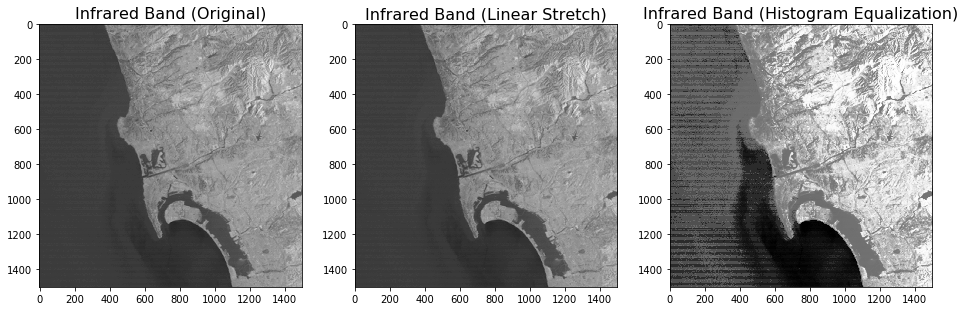

In [76]:
# b) linear stretch
plt.figure(figsize=(16, 10))

# a) no contrast enhancement
plot_band_graysc(plt, 131, ir, 'Infrared Band (Original)')

# b) linear stretch
plot_band_graysc(plt, 132, ir_lin_stretch.astype('uint8'), 'Infrared Band (Linear Stretch)')

# c) historgram equalization
ir_hist_equalized = cv2.equalizeHist(ir)
plot_band_graysc(plt, 133, ir_hist_equalized, 'Infrared Band (Histogram Equalization)')

plt.show()

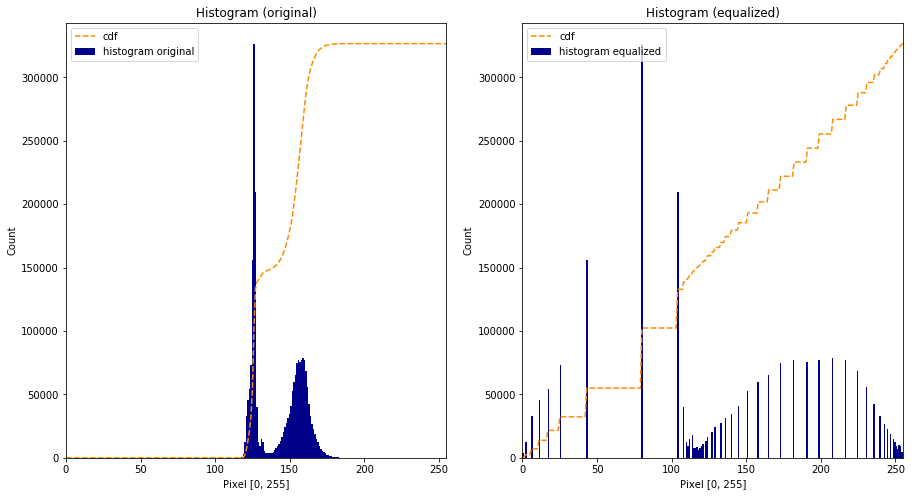

In [204]:
def plot_hist(_plt, _subplot_num, _data, hist_type, title='Histogram'):
    """
    _plt [matplotlib.pyplot]
    _data [2D Numpy array] input data
    
    Reference code: *StackOverFlow link here*
    """
    flattened_data = _data.flatten()
    hist, bins = np.histogram(flattened_data, 256, [0, 255])

    # cumulative distribution function
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max() / cdf.max()

    plt.subplot(_subplot_num)
    plt.plot(cdf_normalized, color='darkorange', linestyle='--')
    plt.hist(flattened_data, 256, [0, 255], color='darkblue')
    plt.xlim([0, 255])
    plt.xlabel('Pixel [0, 255]')
    plt.ylabel('Count')
    plt.title('{0} ({1})'.format(title, hist_type))
    plt.legend(('cdf','histogram ' + hist_type), loc='upper left')

plt.figure(figsize=(15, 8))
plot_hist(plt, 121, ir, 'original')
plot_hist(plt, 122, ir_hist_equalized, 'equalized')
plt.show()

>“Nothing is harder to image than the past. It is imperative that all Landsat observations are archived and made available to users.”
— Wulder et al., 2015, The global Landsat archive: Status, consolidation, and direction,
Aug 23, 2016

## Exercise 3:

1. Use appropriate bands and contrast enhancement to make natural looking RGB image **DONE**<br />
    a) bands 1 to 3<br />
    b) histogram equalization<br />

2. Why does image look blue without hist equalization?<br />

Landsat instruments can detect infrared and visible wavelengths. Landsat is a passive sensor that uses Sun's radiation as the radiation source (i.e. does not emit its own). It 'primarily detects' longwave radiation reflected from the surface of the Earth, the portion of the incident solar radiation that is not absorbed by the Earth's surface. It is possible that the original image looks blue/purple due to scattering of blue light in the atmosphere. (We see what is reflected).

Reference:
https://landsat.gsfc.nasa.gov/wp-content/uploads/2014/09/Landsat_MoreThanPrettyPicture.pdf


3. Combine processed RGB images into single img and plot them **DONE**

Notes:<br />
* Blue (b1)
* Green (b2)
* Red (b3)

In [105]:
r = b3
g = b2
b = b1
recovered_img = Image.fromarray(np.stack([r, g, b], axis=2), mode='RGB')
recovered_img.save("san_diego_rgb.jpg")

# Equalizing histogram of each band
blue_eq = cv2.equalizeHist(b)
red_eq = cv2.equalizeHist(r)
green_eq = cv2.equalizeHist(g)

# Combine the equalized bands to form an RGB image
equalized_img = Image.fromarray(np.stack([red_eq, green_eq, blue_eq], axis=2), mode='RGB')
equalized_img.save('san_diego_hist_eq_rgb.jpg')

In [ ]:
def plot_hist(_plt, _subplot_num, _data, hist_type, title='Histogram'):
    """
    _plt [matplotlib.pyplot]
    _data [2D Numpy array] input data
    """
    flattened_data = _data.flatten()
    hist, bins = np.histogram(flattened_data, 256, [0, 255])

    # cumulative distribution function
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max() / cdf.max()

    plt.subplot(_subplot_num)
    plt.plot(cdf_normalized, color='b')
    plt.hist(flattened_data, 256, [0, 255], color='darkorange')
    plt.xlim([0, 255])
    plt.xlabel('Pixel [0, 255]')
    plt.ylabel('Count')
    plt.title('{0} ({1})'.format(title, hist_type))
    plt.legend(('cdf','histogram ' + hist_type), loc = 'upper left')

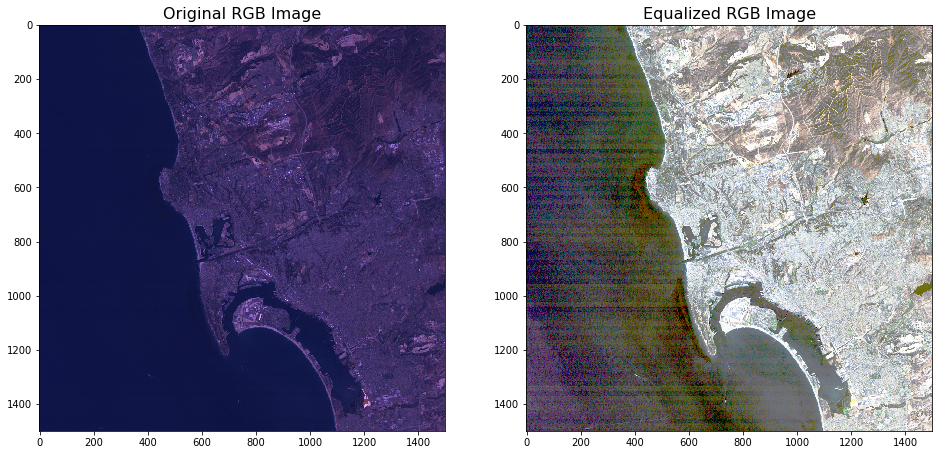

In [108]:
merged_img = cv2.merge([r, g, b])

def plot_img(_plt, subplot_num, _data, title):
    _plt.subplot(subplot_num)
    _plt.title(title, fontsize=16)
    _plt.imshow(_data)
    
plt.figure(figsize=(16,8))
plot_img(plt, 121, merged_img, 'Original RGB Image')

# very cool
plot_img(plt, 122, equalized_img, 'Equalized RGB Image')
plt.show()

In [237]:
#plot RGB and equalized RGB bands
def plot_hist2(_plt, _subplot_num, _data, hist_type, title='Histogram', color_type='green'):
    """
    _plt [matplotlib.pyplot]
    _data [2D Numpy array] input data
    """
    flattened_data = _data.flatten()
    hist, bins = np.histogram(flattened_data, 256, [0, 255])

    # cumulative distribution function
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max() / cdf.max()

    plt.subplot(_subplot_num)
    plt.plot(cdf_normalized, color='black', linestyle='--')
    
    hist = plt.hist(flattened_data, 256, [0, 255], color=color_type, rwidth=0.9)
    plt.xlim([0, 255])
    plt.ylim([0, 500000])
    
    plt.xlabel('Pixel [0, 255]')
    plt.ylabel('Count')
    plt.title('{0} ({1})'.format(title, hist_type))
    
    plt.legend(('cdf','histogram ' + hist_type), loc='upper left')

In [248]:
f, (ax1, ax2, ax3) = plt.subplots(1, 2, 3, sharey=True, sharex='col',  figsize=(14, 6))

plt.figure(figsize=(16, 7))
#red
plot_hist2(plt, 231, r, 'original', 'Red', 'darkred')
plot_hist2(plt, 234, red_eq, 'equalized', 'Red', 'darkred')

#green
ax2 = plot_hist2(plt, 232, g, 'original', 'Green', 'darkgreen')
ax2 = plot_hist2(plt, 235, green_eq, 'equalized', 'Green', 'darkgreen')
ax2.spines["left"].set_visible(False)

#blue
plot_hist2(plt, 233, b, 'original', 'Blue', 'dodgerblue')
plot_hist2(plt, 236, blue_eq, 'equalized', 'Blue', 'dodgerblue')
plt.show()

# Exercise 5 will make plotting multiple figures cleaner by remove unnecessary/overlapping axes
# but leaving these as is

TypeError: subplots() got multiple values for keyword argument 'sharex'

In [242]:
# Plot histograms on the same figure

plt.figure(figsize=(14, 10))
#red
plot_hist2(plt, 211, r, 'original', 'Red', 'darkred')
plot_hist2(plt, 212, red_eq, 'equalized', 'Red', 'darkred')

#green
#plot_hist2(plt, 211, g, 'original', 'Green', 'darkgreen')
plot_hist2(plt, 212, green_eq, 'equalized', 'Green', 'darkgreen')

#blue
plot_hist2(plt, 211, b, r, g, 'original', 'Blue', 'dodgerblue')
plot_hist2(plt, 212, blue_eq, 'equalized', 'Blue', 'dodgerblue')
plt.title('Combined')
plt.show()

TypeError: plot_hist2() takes at most 6 arguments (8 given)

>“Satellite data is revolutionizing the way we map the world and the way we understand the natural and anthropogenic processes acting on Earth.”
— Rory Quinn, marine geoscientist, maritime archaeologist, and Landsat data user, Satellite imagery enhances coastal hydrography, geodatapoint,
Jul 18, 2016

## Exercise 4: 
Image enchancement through filtering<br />

1. Load and show the original image **DONE**
2. Apply a smoothing filter **DONE**
3. Apply a sharpening filter  **DONE**
4. Illuminate from the southwest **DONE**

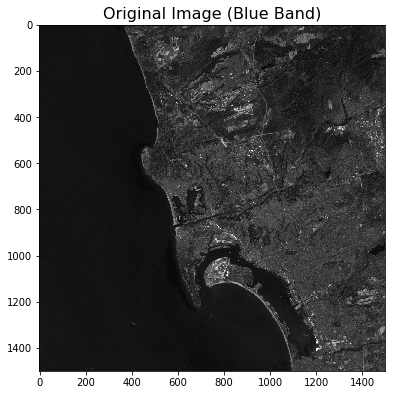

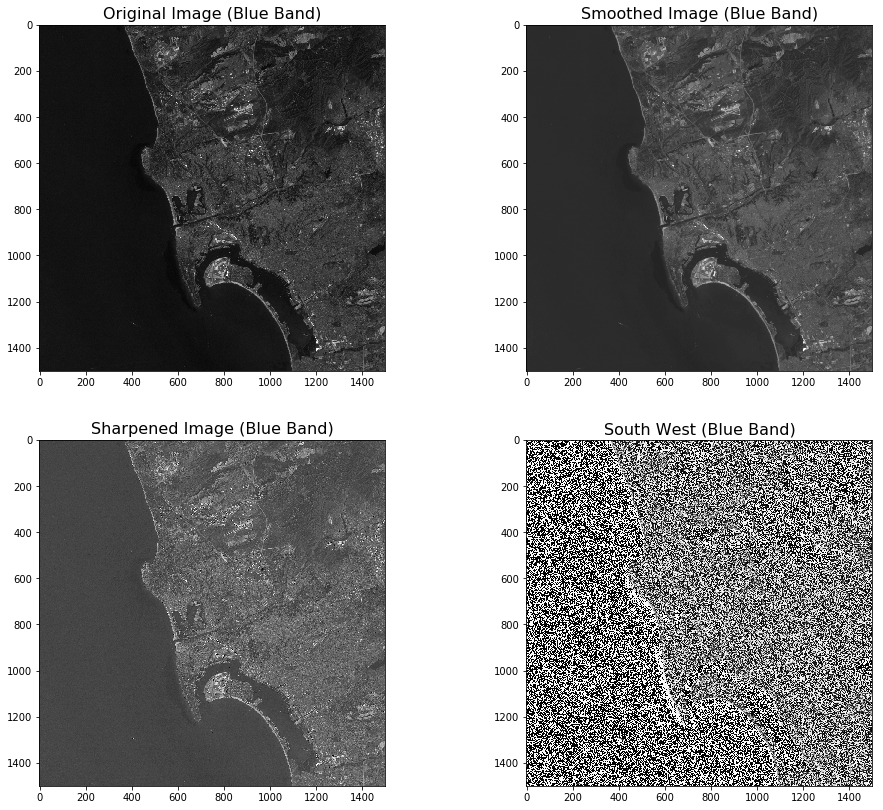

In [44]:
#plot_band_graysc(_plt, subplot_num, _data, title):
import scipy.signal

def apply_smoothing_filter(_data):
    kernel = np.array([[1./9, 1./9, 1./9],[1./9, 1./9, 1./9],[1./9, 1./9, 1./9]])
    # Note: kernel should sum to 1

    # convolve 2d the kernel 
    smoothed = scipy.signal.convolve2d(_data, kernel, mode='same')
    return smoothed.astype(np.uint8)

def apply_sharpening_filter(_data):
    # make a sharpening filter using the kernel used to make a smoothing filter
    
    def _get_identity_operator(dim):
        m = np.zeros((dim, dim))
        m[m.shape[0]/2, m.shape[0]/2] = 1
        return m

    ii = _get_identity_operator(3)
    kernel = np.array([[1./9, 1./9, 1./9],[1./9, 1./9, 1./9],[1./9, 1./9, 1./9]])
   
    # p.285 in Rees 2nd Edition
    k=3
    new_kernel = k*ii + (1-k)*kernel
    #print new_kernel #looks fine
    sharpened = scipy.signal.convolve2d(_data, new_kernel, mode='same')
    return sharpened.astype(np.uint8)

def apply_sobel_filter_sw(_data):
    # illuminate from the southwest
    sobel_sw_kernel = np.array([[0, 1., 2.],[-1., 0, 1.],[-2., -1., 0]])
    illuminated = scipy.signal.convolve2d(_data, sobel_sw_kernel, mode='same')
    return illuminated.astype(np.uint8)
 
# blue band
bb = b1.astype(float)

plt.figure(figsize=(16,14))
plot_band_graysc(plt, 221, bb, 'Original Image (Blue Band)')
plot_band_graysc(plt, 222, apply_smoothing_filter(bb), 'Smoothed Image (Blue Band)')
plot_band_graysc(plt, 223, apply_sharpening_filter(bb), 'Sharpened Image (Blue Band)')
plot_band_graysc(plt, 224, apply_sobel_filter_sw(bb), 'South West (Blue Band)')
plt.show()

>“Landsat has undoubtedly transformed our ability to understand urbanization processes and how cities expand and evolve… the multi-spectrality of Landsat, its relatively high spatial resolution, its revisit period, and especially the long observational record that made millions of scenes publicly available, make Landsat a key asset for the research community.”
— Ran Goldblatt, Big Pixel Initiative of the UC San Diego’s School, A Map for Preserving a Sustainable Society,
Dec 16, 2016